<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base.

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado).

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.metrics           import r2_score

In [2]:
df = pd.read_csv('./input/previsao_de_renda_II.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


In [3]:
# Tratei os dados dessa forma e conseguimos resolver o problema:
media = df['tempo_emprego'].dropna().mean()
df['tempo_emprego'].fillna(media, inplace = True)
df.isna().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [4]:
# Adicionando uma nova coluna 'renda_log' com o logaritmo natural dos valores da coluna 'renda'
df['renda_log'] = np.log(df['renda'])
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
data_ref,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020


In [5]:
# Resetar o índice para transformá-lo em uma coluna
df.reset_index(inplace=True)

# Transformar a coluna "data_ref" em datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenar o DataFrame pela coluna "data_ref"
df = df.sort_values(by='data_ref')

# Selecionar os três últimos meses como base holdout
df_test = df[df['data_ref'] >= df['data_ref'].max() - pd.DateOffset(months=3)]

print(f'''
    Data mínima na base_teste: {df_test['data_ref'].min()}.
    Data máxima na base_teste: {df_test['data_ref'].max()}.
    ''')

df_test.info()


    Data mínima na base_teste: 2015-12-01 00:00:00.
    Data máxima na base_teste: 2016-03-01 00:00:00.
    
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 583335 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               200000 non-null  datetime64[ns]
 1   index                  200000 non-null  int64         
 2   sexo                   200000 non-null  object        
 3   posse_de_veiculo       200000 non-null  object        
 4   posse_de_imovel        200000 non-null  object        
 5   qtd_filhos             200000 non-null  int64         
 6   tipo_renda             200000 non-null  object        
 7   educacao               200000 non-null  object        
 8   estado_civil           200000 non-null  object        
 9   tipo_residencia        200000 non-null  object        
 10  idade                  200000 non-null  int64    

In [6]:
df_train = df[df['data_ref'] < df['data_ref'].max() - pd.DateOffset(months=3)]
#definir como indice 'data_ref'

print(f'''
    Data mínima na base_teste: {df_train['data_ref'].min()}.
    Data máxima na base_teste: {df_train['data_ref'].max()}.
    ''')

df_train.info()


    Data mínima na base_teste: 2015-01-01 00:00:00.
    Data máxima na base_teste: 2015-11-01 00:00:00.
    
<class 'pandas.core.frame.DataFrame'>
Int64Index: 550000 entries, 0 to 516662
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               550000 non-null  datetime64[ns]
 1   index                  550000 non-null  int64         
 2   sexo                   550000 non-null  object        
 3   posse_de_veiculo       550000 non-null  object        
 4   posse_de_imovel        550000 non-null  object        
 5   qtd_filhos             550000 non-null  int64         
 6   tipo_renda             550000 non-null  object        
 7   educacao               550000 non-null  object        
 8   estado_civil           550000 non-null  object        
 9   tipo_residencia        550000 non-null  object        
 10  idade                  550000 non-null  int64         

In [7]:
df_train_short = df_train.drop(['data_ref', 'index'], axis=1)
df_test_short = df_test.drop(['data_ref', 'index'], axis=1)

df_train_short = df_train_short.head(50000)

In [8]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_train_short.renda_log, df_train_short.tempo_emprego, frac=2/3)

# Valores de Y suavizados
lowess_y = lowess[:, 1]

# Valores de X suavizados
lowess_x = lowess[:, 0]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_train_short['lowess'] = f(df_train_short.tempo_emprego)
df_train_short.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,lowess
0,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131,9.547160
33328,F,S,N,0,Assalariado,Superior completo,União,Casa,26,2.347945,2.0,1684.88,7.429450,7.654313
33329,F,N,N,0,Assalariado,Médio,Casado,Casa,40,2.871233,2.0,2480.96,7.816401,7.723619
33330,F,S,N,0,Servidor público,Superior completo,Solteiro,Casa,33,10.430137,1.0,2709.54,7.904534,8.647505
33331,F,N,S,0,Servidor público,Superior completo,Casado,Casa,25,6.301370,2.0,12333.16,9.420047,8.090596


In [9]:
# Ajustando um novo modelo de regressão linear (modelo7) usando a variável 'lowess' como preditora da variável 'renda_log' no DataFrame df_train2
modelo_lowess = smf.ols(formula='renda_log ~ lowess', data=df_train_short).fit()
print(f'R-quadrado ajustado: {modelo_lowess.rsquared_adj:.2%}')

R-quadrado ajustado: 53.87%


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

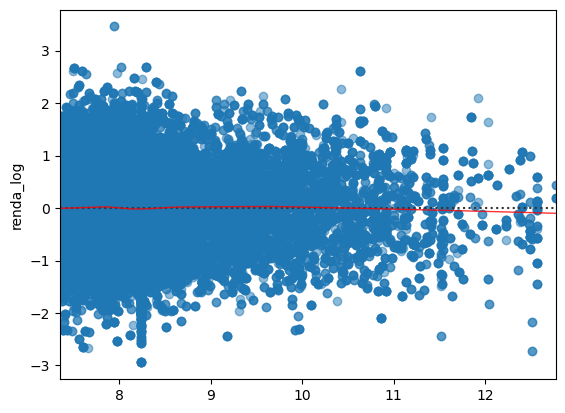

In [10]:
sns.residplot(x=modelo_lowess.predict(), y='renda_log', data=df_train_short,
              lowess=True, scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

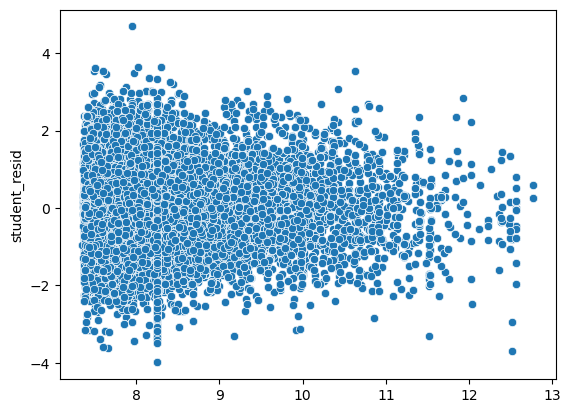

In [11]:
st_res = modelo_lowess.outlier_test()
sns.scatterplot(x = modelo_lowess.predict(), y = st_res.student_resid);

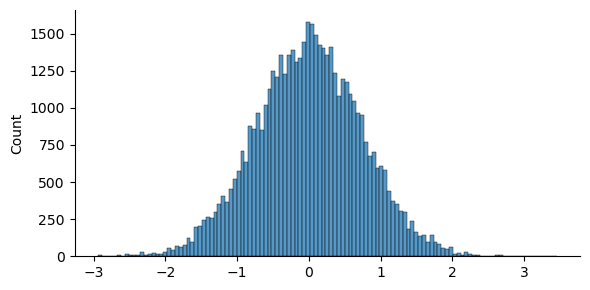

In [12]:
sns.displot(modelo_lowess.resid, height=3, aspect=2);

<Axes: >

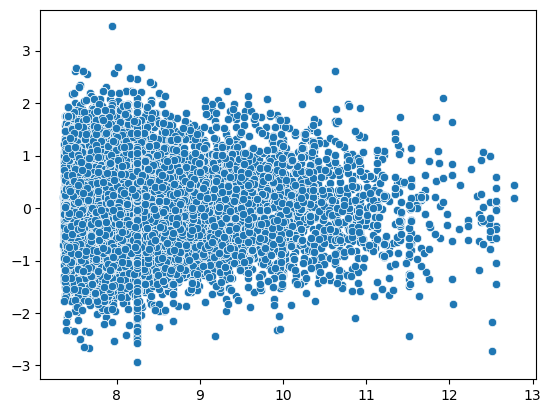

In [13]:
sns.scatterplot(x = modelo_lowess.predict(), y = modelo_lowess.resid)

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

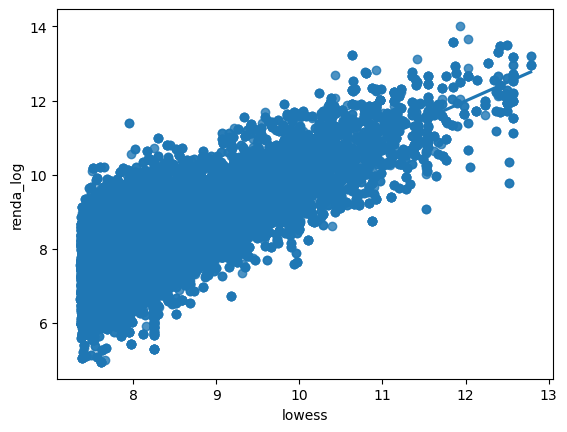

In [14]:
fig, ax = plt.subplots()

sns.regplot(x = 'lowess', y = 'renda_log', data=df_train_short, ax=ax);

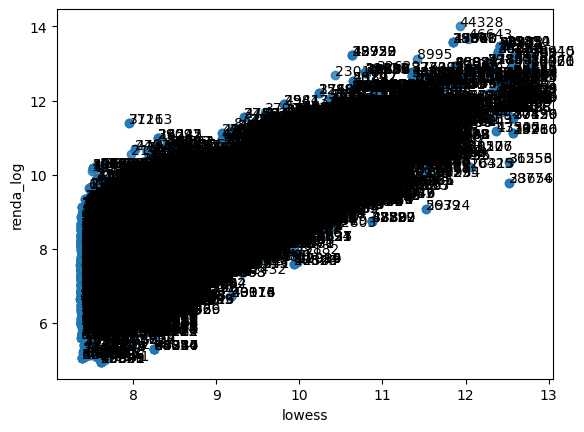

In [15]:
fig, ax = plt.subplots()

sns.regplot(x = 'lowess', y = 'renda_log', data=df_train_short, ax=ax)

for i, txt in enumerate(df_train_short.index.values):
    ax.annotate(str(txt), (df_train_short.loc[i,'lowess'], df_train_short.loc[i,'renda_log']))

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [16]:
df_train_short.corr(method='spearman')

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,lowess
qtd_filhos,1.000000,-0.419814,-0.088001,0.832139,-0.019835,-0.019835,-0.088001
idade,-0.419814,1.000000,0.295613,-0.354096,0.127192,0.127192,0.295613
tempo_emprego,-0.088001,0.295613,1.000000,-0.056479,0.609456,0.609456,1.000000
qt_pessoas_residencia,0.832139,-0.354096,-0.056479,1.000000,-0.003065,-0.003065,-0.056479
renda,-0.019835,0.127192,0.609456,-0.003065,1.000000,1.000000,0.609456
renda_log,-0.019835,0.127192,0.609456,-0.003065,1.000000,1.000000,0.609456
lowess,-0.088001,0.295613,1.000000,-0.056479,0.609456,0.609456,1.000000


In [17]:
variaveis = ['posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

df_train_short_dum = pd.get_dummies(df_train_short[variaveis], drop_first=True)
df_train_short_dum.head()

,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Médio,educacao_Pós graduação,educacao_Superior completo,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
33328,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
33329,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
33330,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0
33331,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0


In [18]:
vif(df_train_short_dum.values, 3)

0.025993161915828844

In [19]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_train_short_dum, i) for i in range(df_train_short_dum.shape[1])]
vars_vif["Feature"] = df_train_short_dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,0.01,posse_de_veiculo_S
1,0.02,posse_de_imovel_S
2,1.00,tipo_renda_Bolsista
3,0.03,tipo_renda_Empresário
4,0.02,tipo_renda_Pensionista
5,0.07,tipo_renda_Servidor público
6,0.17,educacao_Médio
7,1.04,educacao_Pós graduação
8,0.06,educacao_Superior completo
9,0.18,educacao_Superior incompleto


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [20]:
df_test_short = df_test_short.head(18200)

In [21]:
df_test_short['lowess'] = f(df_test_short['tempo_emprego'])

In [22]:
modelo_teste = smf.ols(formula='renda_log ~ lowess', data=df_test_short).fit()
print(f'R-quadrado ajustado na base de teste: {modelo_teste.rsquared_adj:.2%}')

R-quadrado ajustado na base de teste: 52.38%
